In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(os.path.join("drive", "Othercomputers", "My Laptop", "RP", "urban-change-detection"))
os.getcwd()

'/content/drive/Othercomputers/My Laptop/RP/urban-change-detection'

In [3]:
!pip install -r requirements.txt

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

#### Imports


In [4]:
import argparse
import sys
from importlib import reload

sys.path.insert(1, 'siamese_fcn')
sys.path.insert(1, 'datasets')
sys.path.insert(1, 'evaluation')
sys.path.insert(1, 'results')
sys.path.insert(1, 'visualization')
sys.path.insert(1, 'util')

import os
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import DataLoader
import metrics
from metrics import evaluate_net_predictions
from tables import create_tables
from plots import create_figures
from tqdm import tqdm as tqdm
from preprocess_util import reshape_for_torch
from unet import Unet
from siamunet_conc import SiamUnet_conc
from siamunet_diff import SiamUnet_diff
from fresunet import FresUNet
import levir_dataset_loader
import train_test
from levir_dataset_loader import LEVIR_Dataset
import time
from train_test import train
reload(metrics)

<module 'metrics' from '/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/evaluation/metrics.py'>

#### Load Data

In [160]:
N_EPOCHS = 50
FP_MODIFIER = 1
BATCH_SIZE = 4
PATCH_SIZE = 1024
STRIDE = 50
TEST_RUN = False
DIRNAME = os.path.join("..", "data", "LEVIR-CD")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [161]:
import torch
from torch.autograd import Variable
from metrics import evaluate_net_predictions
from tqdm import tqdm as tqdm
import time
import metrics
reload(metrics)




def train(net, net_name, train_dataset, train_loader, val_dataset, criterion, patch_size, n_epochs = 10, save = True, save_dir=f'{time.time()}.pth.tar', weights = [1, 1]):

    optimizer = torch.optim.Adam(net.parameters(), weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.95)
    epoch_metrics = {"train": [], "val": []}

    for _ in range(n_epochs):
        net.train()

        for batch in tqdm(train_loader):
            I1 = Variable(batch['I1'].float().to(device))
            I2 = Variable(batch['I2'].float().to(device))
            label = Variable(batch['label'].float().to(device))


            optimizer.zero_grad()
            output = net(I1, I2).to(device)

            output_rounded = output
            label_rounded = (label / 255).long().to(device)  # Assuming label values are in range [0, 255]

            loss = criterion(output_rounded, label_rounded)


            loss.backward()
            optimizer.step()

        scheduler.step()

        epoch_metrics['train'].append(evaluate_net_predictions(net, criterion, train_dataset, patch_size))
        epoch_metrics['val'].append(evaluate_net_predictions(net, criterion, val_dataset, patch_size))


    if save:

        torch.save(net.state_dict(), save_dir)


    return epoch_metrics




In [162]:
import gc
torch.cuda.empty_cache()
gc.collect()

68345

In [163]:
# torch.no_grad()

train_dataset = LEVIR_Dataset(DIRNAME, "train", STRIDE, PATCH_SIZE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

weights = torch.FloatTensor(train_dataset.weights).to(device)

train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

test_dataset = LEVIR_Dataset(DIRNAME, "test", STRIDE, PATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

val_dataset = LEVIR_Dataset(DIRNAME, "val", STRIDE, PATCH_SIZE)
val_loader = DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, num_workers = 1)

In [164]:
import torch.nn.functional as F

net, net_name = SiamUnet_conc(3, 2), 'FC-Siam-conc'
net.to(device)

print(weights)
# Compute binary cross-entropy loss
# criterion = torch.nn.MSELoss()
# criterion = nn.BCELoss()
criterion = nn.NLLLoss(weight=weights)

# Compute binary cross-entropy loss with class weights
# loss = F.nll_loss(output_flat, label_flat, weight=class_weights)

tensor([ 23.4038, -21.4038], device='cuda:0')


In [165]:
save_dir = f'{net_name}-{time.time()}.pth.tar'
training_metrics = train(net, net_name, train_dataset, train_loader, val_dataset, criterion, PATCH_SIZE, n_epochs=10, save=True, save_dir = save_dir, weights=weights)

  0%|          | 0/112 [00:00<?, ?it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 112/112 [01:52<00:00,  1.01s/it]


In [185]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader, SubsetRandomSampler
import os
import torch
from torch.autograd import Variable
import numpy as np

def examine_subset(net, model_name, dataset, num_samples, device):

    p, q = num_samples // 4, 4

    fig = plt.figure(figsize=(10, q * 2))
    outer = gridspec.GridSpec(num_samples // 4, 4)
    fig.suptitle(model_name, fontsize=16)

    indices = torch.randperm(len(dataset)).tolist()[:num_samples]
    sampler = SubsetRandomSampler(indices)

    batch_size = 1
    data_loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)

    k = 0
    for i in range(p):
        for j in range(q):
            batch = next(iter(data_loader))

            img1 = batch['I1']
            img2 = batch['I2']
            label = batch['label']
            I1 = Variable(batch['I1'].float().to(device))
            I2 = Variable(batch['I2'].float().to(device))
            label = Variable(batch['label'].float().to(device))

            output = net(I1, I2)

            img1 = np.transpose(np.squeeze(img1.cpu().numpy()), (1, 2, 0))
            img2 = np.transpose(np.squeeze(img2.cpu().numpy()), (1, 2, 0))
            label = np.squeeze(label.cpu().numpy())
            output = np.round(np.squeeze(output.cpu().detach().numpy())[0] -np.squeeze(output.cpu().detach().numpy())[1])

            inner = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=outer[i, j], wspace=0.1, hspace=0.1)

            ax1 = plt.Subplot(fig, inner[0, 0])
            ax1.imshow(img1)
            ax1.set_title('T1')
            ax1.axis('off')
            fig.add_subplot(ax1)

            ax2 = plt.Subplot(fig, inner[0, 1])
            ax2.imshow(img2)
            ax2.set_title('T2')
            ax2.axis('off')
            fig.add_subplot(ax2)

            ax3 = plt.Subplot(fig, inner[1, 0])
            ax3.imshow(label)
            ax3.set_title('GT')
            ax3.axis('off')
            fig.add_subplot(ax3)

            ax4 = plt.Subplot(fig, inner[1, 1])
            ax4.imshow(output)
            ax4.set_title('OUT')
            ax4.axis('off')
            fig.add_subplot(ax4)

    os.makedirs(os.path.join('results', 'data_examination', model_name), exist_ok=True)
    plt.savefig(os.path.join('results', 'data_examination', model_name, 'random_subset.png'))


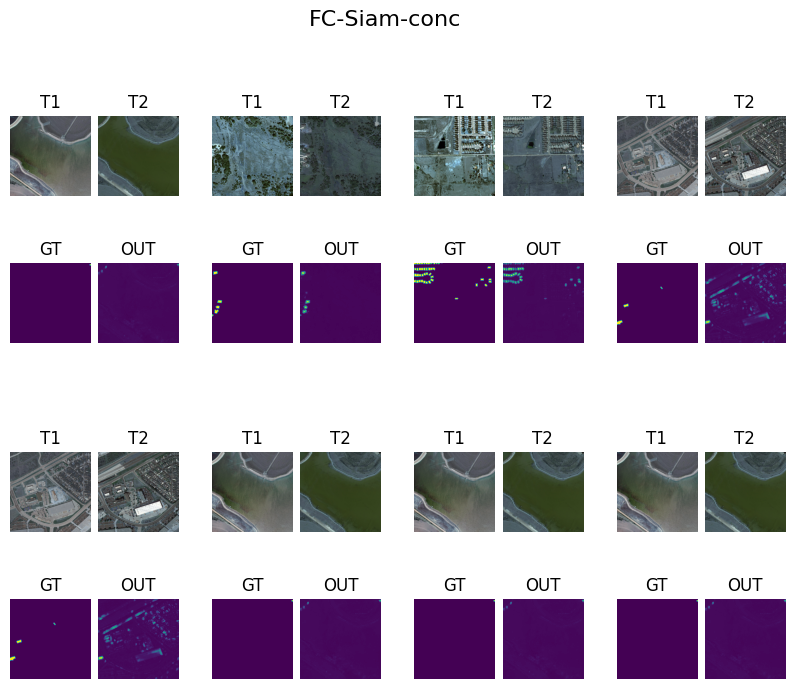

In [187]:
# from data_examination import examine_subset
# reload(data_examination)

examine_subset(net, net_name, train_dataset, 10, device)

In [28]:
test_metrics = evaluate_net_predictions(net, criterion, test_dataset, PATCH_SIZE)

/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/visualization/plots.py:23: RuntimeWarning: invalid value encountered in scalar divide
  train_f1 = [2 * p * r / max(1, (p + r)) for p, r in zip(train_precision, train_recall)]
/content/drive/Othercomputers/My Laptop/RP/urban-change-detection/visualization/plots.py:24: RuntimeWarning: invalid value encountered in scalar divide
  val_f1 = [2 * p * r / max(1, (p + r))  for p, r in zip(val_precision, val_recall)]


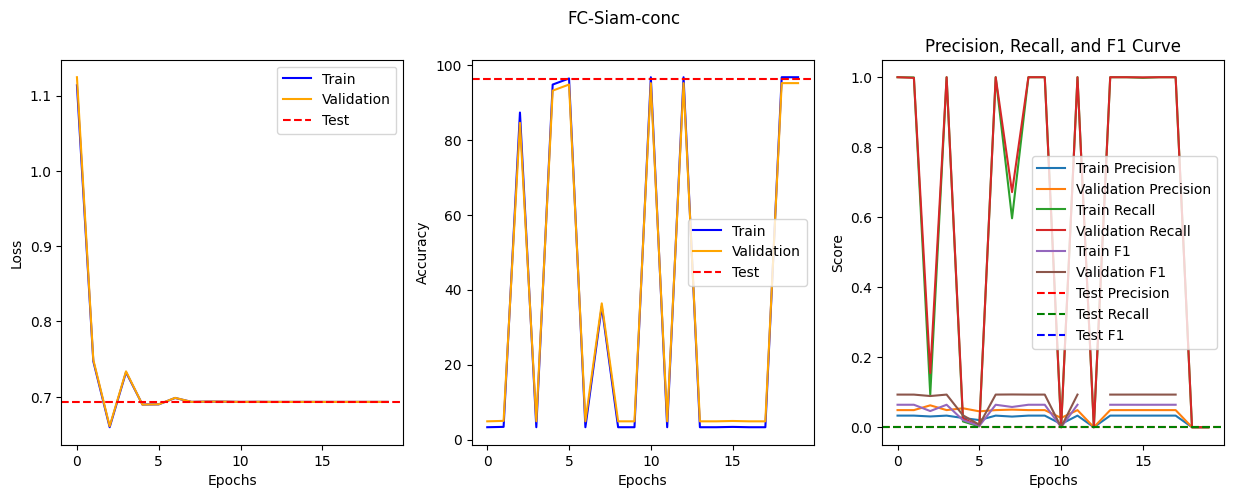

In [144]:
import tables
import plots
from tables import create_tables
from plots import create_figures


create_figures(training_metrics, test_metrics, net_name)
# create_tables(training_metrics, test_metrics, net_name)